# Тестовое задание на должность Product Analyst/Junior Data Analyst в компанию 3205.team
Телефон для связи: 89119526959

Телеграмм для связи: @vadyasss

Почта для связи: filipenko.vad@gmail.com

##Задание 1
1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ
(cohorting event - оформление пробного периода, когорта представляет собой кол-во
возможных операций).
2. Спрогнозировать, каким будет LTV на полгода.
3. Построить график, который будет отображать кривую фактического LTV на
фоне кривой прогнозируемого LTV.
4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения
платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский,
цель: узнать как окупятся наши инвестиции).

### Exploratory Data Analysis





Перед тем как рассчитать и спрогнозировать LTV и ROMI, необходимо изучить имеющиеся данные.

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Изменим стиль наших графиков
plt.style.use('ggplot')

In [ ]:
# Считаем данные из Excel файла
data = pd.read_excel('/content/drive/MyDrive/Colab Data/test case data analyst.xlsx')
data.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [ ]:
print(f'Есть данные за период с {data.purchase_date.dt.date.min()} по {data.purchase_date.dt.date.max()}\n')
print(f'Количество уникальных пользователей - {data.user_id.nunique()}')

Есть данные за период с 2020-01-01 по 2020-02-20

Количество уникальных пользователей - 62909


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


По итогу мы имеем информацию о 62909 уникльных пользователей за период с 2020-01-01 по 2020-02-20 и 114200 записей за этот период. 

In [ ]:
print(f'Количество дублирующих записей - {data.duplicated().sum()}')
# Избавимся от дубликатов:
data = data.drop_duplicates()

Количество дублирующих записей - 84


In [ ]:
print(data['is_trial_period'].value_counts())
print('\n')
print(data['product_id'].value_counts())
print('\n')
print(data['quantity'].value_counts())

True     62944
False    51172
Name: is_trial_period, dtype: int64


1week_4.99_USD_subscription_7days_trial    114116
Name: product_id, dtype: int64


1    114116
Name: quantity, dtype: int64


Видно, что в столбцах '*product_id*' и '*quantity*' по одному значению, так что можно отбросить эти столбцы. Главное запомнить, что одна неделя подписки приносит нам 4.99$.

In [ ]:
# Отбросим неинформативные столбцы
data = data.drop(columns=['product_id', 'quantity'])
data.head()

,is_trial_period,purchase_date,user_id
0,False,2020-02-19,9484222
1,False,2020-02-17,9422402
2,False,2020-02-18,4997991
3,False,2020-02-18,9455582
4,False,2020-02-16,8803657


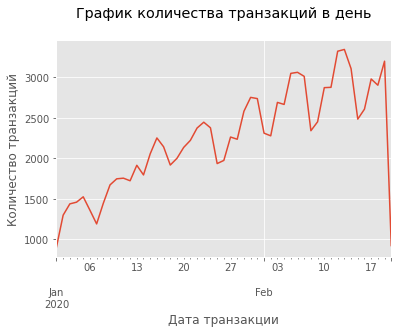

In [ ]:
# Построим график количества транзакций в день (как пробная неделя, так и покупка) 
groupby_date = data.groupby('purchase_date')['user_id'].count()
groupby_date.plot()
plt.title('График количества транзакций в день\n')
plt.xlabel('Дата транзакции')
plt.ylabel('Количество транзакций');

На графике видно падение в последний день февраля, видимо данные еще не успели собраться до конца, поэтому стоит изучить этот день подробнее и если что, то исключить его из общих данных.

Text(0, 0.5, 'Количество транзакций')

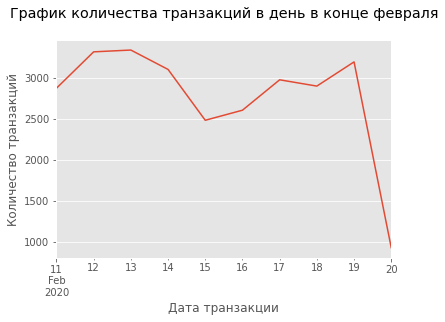

In [ ]:
data_feb_last_days = data[data['purchase_date'] > '2020-02-10']
groupby_feb_last_days = data_feb_last_days.groupby('purchase_date')['user_id'].count()
groupby_feb_last_days.plot()
plt.title('График количества транзакций в день в конце февраля\n')
plt.xlabel('Дата транзакции')
plt.ylabel('Количество транзакций')

Данные за 20 февраля действительно сильно выбиваются, поэтому стоит исключить их из общей таблицы.


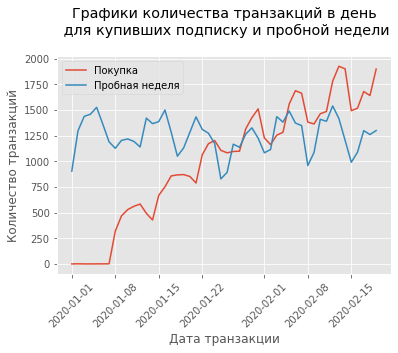

In [ ]:
# Исключим данные за 2020-02-20
data = data[data['purchase_date'] <= '2020-02-19']

# Построим графики зависимости транзакций в день для пробной недели и покупки платной версий 
groupby_date = data.groupby(['purchase_date', 'is_trial_period'])['user_id'].count().reset_index()
sns.lineplot(x='purchase_date', y='user_id', data=groupby_date, hue='is_trial_period')
plt.title('Графики количества транзакций в день\n для купивших подписку и пробной недели\n')
plt.xlabel('Дата транзакции')
plt.xticks(rotation=45)
plt.ylabel('Количество транзакций')
plt.legend(labels=['Покупка','Пробная неделя', ]);


На графике видна некая сезонность, построим график зависимости среднего количества транзакций в зависимости от дня недели и типа транзакции.

Для этого создадим новую колонку с днём недели.

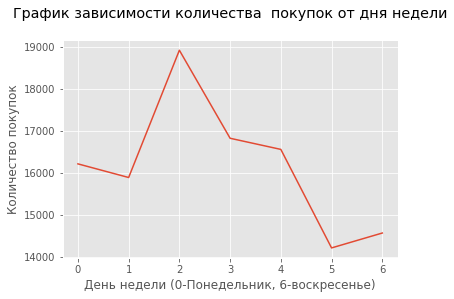

In [ ]:
# Выделим день недели, когда была совершена транзакция(0 - Понедельник, 6 - воскресенье)
data['day_of_week'] = data['purchase_date'].dt.dayofweek
groupby_dayofweek = data.groupby(['day_of_week'])['user_id'].count()
groupby_dayofweek.plot()
plt.title('График зависимости количества  покупок от дня недели\n')
plt.xlabel('День недели (0-Понедельник, 6-воскресенье)')
plt.ylabel('Количество покупок');


На графике видно, что наибольшее количество покупок происходит в середине рабочей недели. Это логично сходится с тем, что чаще всего наше приложение используется во время работы для сканирования документов, а во время выходных происходит спад.

###Рассчёт текущего LTV пользователя, используя когортный анализ.

Рассчитаем текущий LTV пользователя, используя когортный анализ.
Так как деньги за пользование нашим сервисом списываются каждую неделю и количество данных у нас ограничено всего 2 месяцами, используем неделю в качестве когорты.

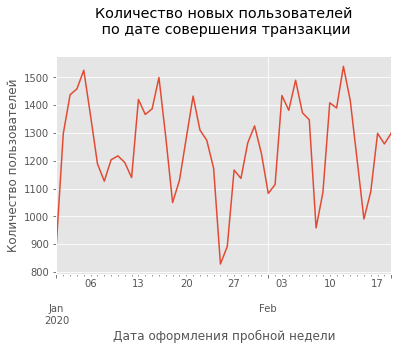

In [ ]:
 # Посмотрим, сколько пользователей оформляло пробную неделю в каждый из дней
 new_users_by_date = data[data['is_trial_period'] == True].groupby('purchase_date')['user_id'].count()
 new_users_by_date.plot()
 plt.title('Количество новых пользователей\n по дате совершения транзакции\n')
 plt.xlabel('Дата оформления пробной недели')
 plt.ylabel('Количество пользователей');

Найдём среднюю конверсию перехода от использования бесплатной недели к покупке платного доступа (хотя бы один раз) за всё доступное время.

Для этого разделим количество уникальных пользователей, которые купили подписку, на количество всех пользователей (включающее в себя и тех, кто оформил только пробный период).

In [ ]:
CR = data[data['is_trial_period'] == False]['user_id'].nunique() / data['user_id'].nunique()
print('Конверсия из пробного периода в оплату - {0:.0%}'.format(CR))

Конверсия из пробного периода в оплату - 31%


У этого приложения отличная конверсия в 31%.

Дальше займемся расчётом LTV для каждой когорты(в нашем случае когорта - неделя, когда была совершена первая транзакция).



Определим в какую дату пользователь оформил подписку.

In [ ]:
# Определим в какую дату пользователь оформил подписку
users_first_date = data[data['is_trial_period'] == True][['user_id', 'purchase_date']]
users_first_date.head()

,user_id,purchase_date
2601,9429240,2020-02-10
2602,6629221,2020-01-14
2603,8428489,2020-01-07
2604,9294519,2020-02-05
2605,7611125,2020-02-14


Определим дату последней покупки для пользователей, совершавших покупку.

In [ ]:
users_last_date = data[data['is_trial_period'] == False].groupby('user_id')['purchase_date'].max().reset_index().rename(columns={'purchase_date':'last_purchase_date'})
users_last_date.head()

,user_id,last_purchase_date
0,404,2020-02-10
1,9010,2020-02-17
2,23403,2020-02-11
3,23647,2020-02-13
4,33989,2020-02-17


Для каждого пользователя, который совершил покупку платного периода определим количество оплат и то, сколько денег он нам принёс с начала использования сервиса. 

In [ ]:
users_pay = data[data['is_trial_period'] == False].groupby(['user_id'])['is_trial_period'].count().reset_index().rename(columns={'is_trial_period':'active_week'})
users_pay['customer_ltv'] = users_pay['active_week'] * 4.99
users_pay.head()

,user_id,active_week,customer_ltv
0,404,1,4.99
1,9010,3,14.97
2,23403,3,14.97
3,23647,3,14.97
4,33989,3,14.97


Соединим информацию о дате оформления пробного периода с CLTV для каждого пользователя и датой последней покупки.

In [ ]:
# Объединим информацию о дате первой покупки с CLTV
users_info = pd.merge(users_pay, users_first_date, how='left')
# Объединим информацию о дате последней покупки с CLTV
users_info = pd.merge(users_info, users_last_date, how='left')

# После объединения таблиц, появились дублирующие записи(из-за наличия двух дат оформления пробного периода)
print(users_info[users_info.duplicated('user_id',keep=False)])

# Исключим эти данные из результирующей таблицы, оставив информаци о дате, которая появилась позже
users_info = users_info.drop_duplicates('user_id', keep='last')

# Исключим данные, где время последней покупки меньше, чем время первой покупки
wrong_users = users_info[users_info['purchase_date'] > users_info['last_purchase_date']]
print(f'\nWrong users:\n {wrong_users}')
users_info = users_info[users_info['purchase_date'] < users_info['last_purchase_date']]

# Исключим пользователя, который совершил первую покупку на следующий день после оформления пробной недели
users_info.drop(users_info[users_info['user_id'] == 9112200].index, inplace=True)


       user_id  active_week  customer_ltv purchase_date last_purchase_date
2500   8211712            5         24.95    2020-02-19         2020-02-12
2501   8211712            5         24.95    2020-01-02         2020-02-12
6474   8498380            5         24.95    2020-02-05         2020-02-19
6475   8498380            5         24.95    2020-01-09         2020-02-19
7888   8608883            5         24.95    2020-01-13         2020-02-16
7889   8608883            5         24.95    2020-01-12         2020-02-16
9811   8735396            4         19.96    2020-01-17         2020-02-14
9812   8735396            4         19.96    2020-01-23         2020-02-14
15011  9126292            2          9.98    2020-02-03         2020-02-15
15012  9126292            2          9.98    2020-02-01         2020-02-15
16901  9287947            1          4.99    2020-02-06         2020-02-12
16902  9287947            1          4.99    2020-02-05         2020-02-12
18470  9421896           

Посмотрим, как распределяются пользователи по количеству оплаченных недель.

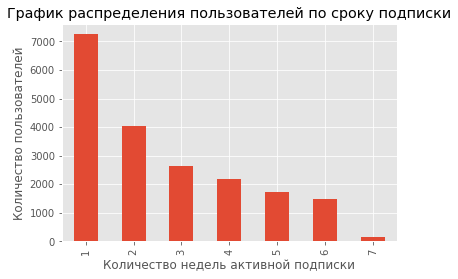

In [ ]:
users_info['active_week'].value_counts().plot(kind='bar')
plt.title('График распределения пользователей по сроку подписки\n')
plt.xlabel('Количество недель активной подписки')
plt.ylabel('Количество пользователей');

Выделим из информации о дате покупки данные о неделе и сгруппируем по этому признаку.


In [ ]:
# Формируем новый признак - разница в неделях между оформлением пробного периода и 
users_info['weeks_since_first_spend'] = users_info['last_purchase_date'].dt.isocalendar().week\
                                    - users_info['purchase_date'].dt.isocalendar().week

print(users_info[users_info['weeks_since_first_spend'] == 0].T)

# Сгруппируем пользователей по тому, сколько времени прошло с их первой покупки и сколько денег они наи принесли
users_ltv = users_info.groupby('weeks_since_first_spend')['customer_ltv'].mean()
# users_ltv

Empty DataFrame
Columns: []
Index: [user_id, active_week, customer_ltv, purchase_date, last_purchase_date, weeks_since_first_spend]


Построим график зависимости LTV от количества недель, прошедшего с первой покупки.

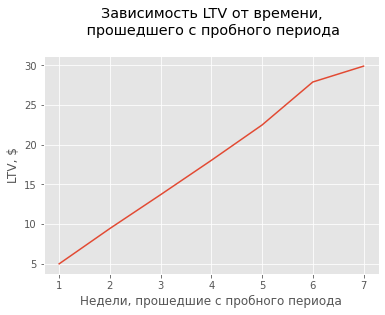

In [ ]:
users_ltv.plot()
plt.title('Зависимость LTV от времени,\n прошедшего с пробного периода\n')
plt.xlabel('Недели, прошедшие с пробного периода')
plt.ylabel('LTV, $');

###Спрогнозируем LTV на следующие полгода.
На графике мы видим линейную зависимость, поэтому мы можем спрогнозировать LTV на полгода с помощью линейной регрессии. Необходимо найти параметры коффициенты прямой, которые будут оптимальными относительно известных данных.

In [ ]:
# Получим доступ ко всем столбцам нашего DataFrame
users_ltv = users_ltv.reset_index()

In [ ]:
# Импортируем statsmodels для вычисления коэффициентов нашей пронозной прямой
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Вычисление коэффициентов прямой
res = smf.ols('customer_ltv ~ weeks_since_first_spend', data = users_ltv).fit()
print(res.params)

Intercept                  0.865085
weeks_since_first_spend    4.297458
dtype: float64


In [ ]:
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           customer_ltv   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     952.5
Date:                Tue, 06 Jul 2021   Prob (F-statistic):           6.70e-07
Time:                        10:05:41   Log-Likelihood:                -6.6170
No. Observations:                   7   AIC:                             17.23
Df Residuals:                       5   BIC:                             17.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8651      0.623      1.389      0.223      -0.736       2.466
weeks_since_first_spend     4.2975      0.139     30.863      0.000       3.940       4.655
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.428
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.233
Skew:                           0.388   Prob(JB):                        0.890
Kurtosis:                       3.444   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

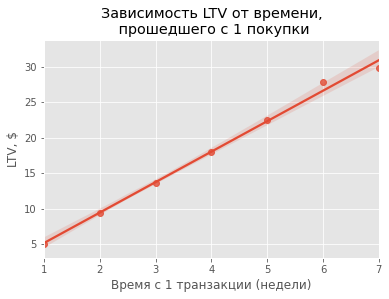

In [ ]:
# Построение графика с доверительным интервалом
sns.regplot(x='weeks_since_first_spend', y='customer_ltv', data=users_ltv, )
plt.title('Зависимость LTV от времени,\n прошедшего с пробного периода')
plt.xlabel('Время с 1 транзакции (недели)')
plt.ylabel('LTV, $');

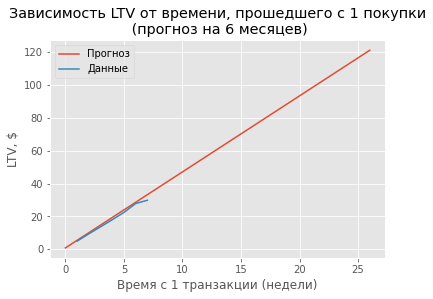

In [ ]:
# Рассчитаем погнозное значение LTV за первые полгода 2020 года (28 недель)
predicted_week = np.linspace(0,28,27)
predicted_ltv = predicted_week * res.params[1] + res.params[0]
predicted_ltv_6_month = pd.DataFrame(data={'predicted_ltv': list(predicted_ltv)})

# Построим график прогноза роста LTV 
plt.plot(predicted_ltv_6_month)
plt.plot(range(1,8), users_ltv['customer_ltv'])
plt.title('Зависимость LTV от времени, прошедшего с 1 покупки\n (прогноз на 6 месяцев)')
plt.xlabel('Время с 1 транзакции (недели)')
plt.ylabel('LTV, $')
plt.legend(['Прогноз', 'Данные']);

In [ ]:
ltv_6_month = 28 * res.params[1] + res.params[0]
print('Пронозное LTV, для пользователя через 6 месяцев - {:.2f}'.format(ltv_6_month))

Пронозное LTV, для пользователя через 6 месяцев - 121.19


Пронозное LTV, для пользователя через 6 месяцев - 121.19

###Рассчитаем ROMI за 4 недели

Для рассчёта ROMI нам надо знать количество количество платных транзакций за этот период, чтобы посчитать доход и общее количество клиентов на привлечение которых был потрачен рекламный бюджет.

In [ ]:
#Ограничиваем данные 4 неделями
data_4_week = data[data['purchase_date'] < '2020-01-29']
#Считаем доход, умножая все платные транзакции на 4.99$
revenue = data_4_week[data_4_week['is_trial_period'] == False]['is_trial_period'].count() * 4.99
#Считаем расход, умножая кадого уникального юзера, оплатившего подписку на 6$
expense = data_4_week[data_4_week['is_trial_period'] == False]['user_id'].nunique() * 6.0
 
ROMI_4_week = (revenue - expense) / expense * 100
print(f'ROMI за 4 недели составил - {ROMI_4_week}%')

ROMI за 4 недели составил - 44.71%


ROMI за 4 недели составил всего 44.71%, это значит, что на каждый вложенный в рекламу доллар принес 0.44$ прибыли.

Это не такой большой коэффициент сейчас, но с увеличение базы постоянных подписчиков ROMI будет расти.

##Задание 2

###Запрос для вычисления средней суммы sale_amount:

SELECT CAST(SUM(sale_amount) / COUNT(sale_amount) AS NUMERIC(10,0))
FROM orders;

###Запрос для вычисления медианы суммы sale_amount:

SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY sale_amount) FROM orders;

###Запрос для поиска задублированных в результате ошибки транзакций:

SELECT * FROM
  (SELECT *, COUNT(*)
  OVER 
     (PARTITION BY
     transaction_id, 
     datetime
     ) AS count
  FROM purchases) table_with_count
  WHERE table_with_count.count > 1;




## Задание 3
Продуктовый менеджер сформировал гипотезу, что новая версия экрана продаж будет
лучше перформить по сравнению со старой, в связи с тем, что на новом экране продаж
более понятно описаны преимущества платной версии приложения.
Продуктовый менеджер ожидает увеличение уровня конверсии из установки в покупку
платной версии приложения. Приложение тем временем уже очень активно
продвигается на рынке, каждый день привлекается в среднем по 30 000 новых
пользователей, текущий уровень конверсии из установки в покупку 5%.
Как бы вы предложили проверить данную гипотезу, какие инструменты и тесты бы
использовали в процессе проверки?

Для того, чтобы проверить гипотезу продуктового менеджера можно провести классический A/B тест.

###A/B тест

Проведение A/B теста можно разделить на несколько шагов:
1. Постановка цели.

Глобальная цель нашей компании - увеличение количества пользователей, совершивших покупку. Один из способов - увеличение конверсии.
2. Выбрать метрику.

Для нашего теста ключевая метрика - конверсия из установки в покупку.
3. Определиться с гипотезами.

Нулевая гипотеза: 
Изменения ни к чему не приведут, конверсия останется прежней.

Альтернативная гипотеза:
Изменения экрана продаж приведёт к повышению конверсии, минимум на 0.25%.
4. Спроектировать дизайн эксперимента.

С помощью калькулятора Эвона-Мюллера оценим количество времени, которое нам понадобится на проведение теста и количество людей, которым мы собираемся показать разные варианты.
С помощью этого калькулятора(https://www.evanmiller.org/ab-testing/sample-size.html#!5;75;5;5;1) я рассчитал, что при базовой конверсии в 5% и минимальном наблюдаемом эффекте в плюс-минус 0.25 процента нам необходимо, чтобы в каждой из групп было показано ~105000 пользователей, учитывая наше количество установок в 30000 пользователей в день, получаем, что разделив на 2 равные группы наших пользователей, время проведения эксперимента займёт неделю.

5. Провести эксперимент и ждать его окончания.

6. Проанализировать результаты.

Так как конверсия имеет вид распределения Бернулли(покупка либо совершена, либо нет), то в качестве теста для вычисления p-value можно использовать Chi-Squared Test и в зависимости от результатов p-value мы либо подтвердим нулевую гипотезу, либо примем альтернативную. 
В качестве исходной точки я бы использовал стандартное значение p-value = 0.05 для доказательства статистичекой значимости нашей гипотезы.



